In [1]:
#Correlation Network Analysis

In [2]:
#Gene network analysis is a method designed to identify sub-networks (modules) of correlated genes, which are likely to be co-expressed.
#This can be helpful in identification of sub-networks (modules) of genes that contribute to disease.
#In this example, we will cover how to create a pairwise correlation matrix of genes, as well as how to associate them with disease.

In [52]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import networkx as nx
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import json
import scipy
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multitest import multipletests
import random

In [4]:
#Load in the required data
datExpr = pd.read_csv('/data/recode/mic_datExpr_pseudobulk.csv', index_col = 0)
metadata = pd.read_csv('/data/recode/mic_metadata_pseudobulk.csv', index_col = 0)

In [5]:
datExpr

,SAR1A,IER3,ATXN7,MRPL32,RASGEF1C,HMG20B,RAB11FIP2,GEM,TREM1,MEPE,...,MAN1A2,EDA,TMLHE,ECH1,APEX2,FCGR3A,SMUG1,HEATR5A,ARL2-SNX15,NRBP2
donor_id,,,,,,,,,,,,,,,,,,,,,
1,3.465736,19.238222,4.158883,0.693147,29.347748,1.386294,4.158883,0.693147,0.000000,0.000000,...,7.336937,5.950643,3.465736,0.000000,1.386294,4.158883,0.693147,2.079442,1.386294,4.969813
2,1.386294,5.662960,11.783503,0.693147,65.928200,6.931472,4.158883,0.000000,0.000000,0.000000,...,5.950643,11.090355,4.852030,1.386294,0.000000,5.545178,0.693147,5.257495,0.693147,1.791759
3,0.000000,1.386294,2.079442,0.000000,0.693147,0.693147,0.693147,0.000000,0.000000,0.000000,...,2.079442,1.386294,0.000000,0.000000,0.000000,1.386294,0.000000,1.386294,0.000000,0.693147
4,0.000000,3.871201,0.693147,0.000000,4.852030,2.079442,1.386294,0.000000,0.000000,0.000000,...,4.158883,2.772589,0.693147,1.386294,0.000000,4.852030,1.098612,0.693147,0.000000,1.386294
5,0.693147,3.465736,5.257495,1.386294,18.139610,2.772589,2.772589,0.000000,0.000000,0.000000,...,7.336937,6.931472,2.772589,2.302585,0.000000,13.693045,1.386294,1.386294,3.465736,0.693147
6,9.639523,13.117681,11.495820,3.465736,4.158883,10.227308,4.969813,0.693147,0.000000,0.000000,...,23.920353,13.575262,6.238325,3.465736,3.583519,40.385986,3.178054,6.461468,8.317766,3.178054
7,9.704061,35.180607,62.279015,9.234056,288.971860,13.575262,27.843670,1.791759,0.000000,1.098612,...,76.418350,73.423744,57.480230,2.772589,3.871201,64.018660,5.257495,25.764229,6.238325,7.742402
8,32.002552,33.506630,44.884666,9.010914,153.331540,15.249238,13.169796,0.693147,0.000000,0.693147,...,53.032536,58.747612,25.071081,4.852030,5.545178,19.525904,8.723231,24.495718,39.627174,7.624619
9,68.281780,40.032640,44.021620,10.397207,53.032536,9.704061,22.991640,6.356108,1.791759,3.465736,...,52.796970,54.706512,21.487562,9.010914,2.079442,63.429740,2.772589,27.725887,432.745900,4.852030


In [6]:
metadata

,donor_id.1,BraakStage,nUMI,nGene,seurat.subclusters,development_stage,AD,Normal
donor_id,,,,,,,,
1,1,0,302.0,268,1,50,0,1
2,2,0,676.0,553,1,60,0,1
3,3,0,219.0,193,0,71,0,1
4,4,2,348.0,295,0,72,1,0
5,5,2,447.0,328,1,77,1,0
6,6,2,376.0,328,2,87,1,0
7,7,2,1399.0,965,1,80,1,0
8,8,6,619.0,500,0,72,1,0
9,9,6,531.0,437,0,82,1,0


In [7]:
#Correlation is a statistical measure that describes the extent to which two variables change together. It indicates the strength and direction of a linear relationship between two variables.
#Correlation analysis for coexpression networks is a method used to study the relationships between genes or proteins by analysing their expression levels across various conditions, tissues, or time points.
#We will be exploring correlation based co-expression networks within this exercise.

In [8]:
#Step 1: 
#You can use the corr function to calculate pairwise pearson correlations between the genes.
correlation_matrix = datExpr.corr()

In [9]:
#Lets view the correlation matrix. You will see that there is a diagonal of the value 1, due to the calculating the correlation between the same gene.
correlation_matrix

,SAR1A,IER3,ATXN7,MRPL32,RASGEF1C,HMG20B,RAB11FIP2,GEM,TREM1,MEPE,...,MAN1A2,EDA,TMLHE,ECH1,APEX2,FCGR3A,SMUG1,HEATR5A,ARL2-SNX15,NRBP2
SAR1A,1.000000,0.725413,0.550172,0.782721,0.178120,0.458616,0.555994,0.894922,0.883286,0.935306,...,0.583341,0.564375,0.344691,0.761134,0.418198,0.484103,0.436019,0.730808,0.929036,0.470999
IER3,0.725413,1.000000,0.918816,0.935587,0.690830,0.812067,0.914412,0.759219,0.448453,0.711565,...,0.920508,0.928746,0.819012,0.787213,0.807146,0.798091,0.732449,0.952399,0.540048,0.763134
ATXN7,0.550172,0.918816,1.000000,0.921869,0.851426,0.904021,0.969570,0.616893,0.260976,0.587285,...,0.973342,0.997346,0.944649,0.756031,0.799638,0.853328,0.774544,0.969896,0.358129,0.666082
MRPL32,0.782721,0.935587,0.921869,1.000000,0.710048,0.834252,0.877108,0.745256,0.501485,0.769248,...,0.956541,0.924576,0.829361,0.788327,0.792718,0.761167,0.804172,0.975609,0.583781,0.749458
RASGEF1C,0.178120,0.690830,0.851426,0.710048,1.000000,0.723740,0.773961,0.233588,-0.087115,0.278654,...,0.851843,0.829699,0.949144,0.315076,0.658739,0.557699,0.711223,0.750371,-0.025997,0.741998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCGR3A,0.484103,0.798091,0.853328,0.761167,0.557699,0.808525,0.924222,0.697209,0.322011,0.548574,...,0.818367,0.853796,0.773017,0.854265,0.671366,1.000000,0.501076,0.811705,0.410511,0.333123
SMUG1,0.436019,0.732449,0.774544,0.804172,0.711223,0.854337,0.620901,0.244287,-0.011956,0.289939,...,0.810370,0.793726,0.709070,0.542013,0.918964,0.501076,1.000000,0.782284,0.092798,0.756906
HEATR5A,0.730808,0.952399,0.969896,0.975609,0.750371,0.877521,0.934270,0.734106,0.444341,0.729074,...,0.959342,0.972649,0.863933,0.820578,0.789737,0.811705,0.782284,1.000000,0.538498,0.694992
ARL2-SNX15,0.929036,0.540048,0.358129,0.583781,-0.025997,0.202662,0.438301,0.927235,0.990324,0.949305,...,0.379077,0.363497,0.172499,0.665918,0.102706,0.410511,0.092798,0.538498,1.000000,0.215255


/tmp/ipykernel_656066/456697685.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method='average')


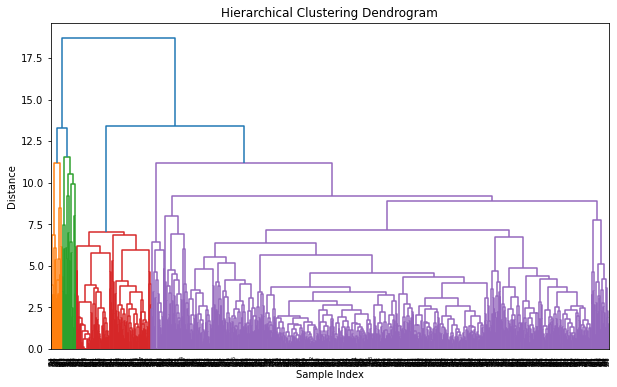

In [10]:
#Step 2:
#Now that we have the correlation matrix, we need to calculate the distance matrix.
#A distance matrix is a mathematical representation that captures the pairwise distances between a set of objects. 
#In hierarchical clustering, distance matrices are used to determine which objects to merge or split based on their pairwise distances.
#So, we will be using the distance matrix in order to calculate clusters between genes, which will form our networks. These are commonly also called communities.

# Perform hierarchical clustering using the dissimilarity values
distance_matrix = 1 - correlation_matrix  # Convert correlation to distance

#The linkage function is used to perform hierarchical clustering on the distance matrix. 
linkage_matrix = sch.linkage(distance_matrix, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [11]:
#Step 3:
#Due to all of the vast correlations, the networks will be very messy each having lots of edges with varying correlation strengths.
#Not all of these are of interest, such as weak correlations. So we would solely like to focus on the strong correlations.

# Define threshold for significant edges (you can adjust this based on your requirement)
threshold = 0.7

# Threshold the correlation matrix to determine significant edges
significant_edges = correlation_matrix > threshold

In [12]:
#Lets have a look at the significant_edges dataframe.
#You can now see that this produces a boolean dataframe which states whether the values are greater than the threshold or not.
significant_edges

,SAR1A,IER3,ATXN7,MRPL32,RASGEF1C,HMG20B,RAB11FIP2,GEM,TREM1,MEPE,...,MAN1A2,EDA,TMLHE,ECH1,APEX2,FCGR3A,SMUG1,HEATR5A,ARL2-SNX15,NRBP2
SAR1A,True,True,False,True,False,False,False,True,True,True,...,False,False,False,True,False,False,False,True,True,False
IER3,True,True,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,False,True
ATXN7,False,True,True,True,True,True,True,False,False,False,...,True,True,True,True,True,True,True,True,False,False
MRPL32,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,False,True
RASGEF1C,False,False,True,True,True,True,True,False,False,False,...,True,True,True,False,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCGR3A,False,True,True,True,False,True,True,False,False,False,...,True,True,True,True,False,True,False,True,False,False
SMUG1,False,True,True,True,True,True,False,False,False,False,...,True,True,True,False,True,False,True,True,False,True
HEATR5A,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,False,False
ARL2-SNX15,True,False,False,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,True,False


In [13]:
#Step 4:
#networkx is a python library designed for network analysis.
# Construct the network from significant edges.
G = nx.Graph()

# Loop through significant edges and add edges to the graph
for i in range(significant_edges.shape[0]):
    for j in range(significant_edges.shape[1]):
        if significant_edges.values[i, j]:
            gene1 = significant_edges.index[i]
            gene2 = significant_edges.columns[j]
            
            # Find the position of gene1 and gene2 in the correlation matrix
            i_corr = np.where(correlation_matrix.index == gene1)[0][0]
            j_corr = np.where(correlation_matrix.columns == gene2)[0][0]
            
            # Add the edge to the graph
            G.add_edge(gene1, gene2, weight=correlation_matrix.iloc[i_corr, j_corr])

# Display the number of nodes and edges in the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 999
Number of edges: 270447


In [14]:
#Step 5:
# Analyse the network
# For example, you can identify clusters/modules using community detection algorithms
communities = nx.algorithms.community.greedy_modularity_communities(G)

In [15]:
communities

[frozenset({'ABCB4',
            'ABCC5',
            'ABHD3',
            'ACO1',
            'ACSF2',
            'ACSL4',
            'ADAMTSL2',
            'ADCY9',
            'ADGRB3',
            'ADGRG5',
            'AGBL4',
            'AHNAK',
            'AIDA',
            'AIF1',
            'AK5',
            'ALCAM',
            'ALOX15B',
            'AMN1',
            'AMPD3',
            'ANKMY1',
            'ANKRD26',
            'ANO6',
            'APEX2',
            'APMAP',
            'APOC1',
            'APOE',
            'APOLD1',
            'ARHGAP11A',
            'ARHGAP29',
            'ARHGAP6',
            'ARHGEF11',
            'ARL14EP',
            'ARNT',
            'ASB14',
            'ASIC2',
            'ASPM',
            'ATAD2',
            'ATG4C',
            'ATP1B3',
            'ATXN7',
            'AUH',
            'AURKB',
            'AZGP1',
            'BAG2',
            'BANF2',
            'BCAR3',
            'BCKDHB',

In [16]:
# Initialise a new graph for community visualisation
community_graph = nx.Graph()

In [17]:
# Add edges between communities based on their connectivity
for i, community in enumerate(communities):
    for node in community:
        community_graph.add_node(node)
        for neighbor in G.neighbors(node):
            if neighbor in community:
                community_graph.add_edge(node, neighbor, weight=G[node][neighbor]['weight'])


In [18]:
# Initialise an empty list to store separated communities
separated_communities = []

# Iterate over the detected communities
for community in communities:
    # Convert the set of nodes into a list and append it to the list of lists
    separated_communities.append(list(community))

In [19]:
# Print or use the separated communities as needed
print(separated_communities)

[['RPL37A', 'SAMD9L', 'SNTG1', 'MECOM', 'OPHN1', 'PBX3', 'RIPOR2', 'NUP210L', 'MSI2', 'GAPT', 'P3H2', 'APOLD1', 'ICA1', 'NOS1AP', 'CWC27', 'LMO7', 'PLAGL1', 'PEX12', 'ULK2', 'GPNMB', 'GALK2', 'INSR', 'AIF1', 'SYNE1', 'SIDT1', 'ZNF844', 'DGKE', 'MT-CO1', 'PRELID2', 'PRH1', 'SGPP1', 'CPVL', 'PGM5', 'PLIN2', 'CHPT1', 'CYTL1', 'C12orf42', 'S100A4', 'AHNAK', 'DGLUCY', 'CNOT6L', 'RAD51AP1', 'STXBP5L', 'CFTR', 'ZCWPW1', 'TXK', 'CHAT', 'ABCB4', 'INPP4B', 'GLIS3', 'CD247', 'CAPS2', 'MFSD11', 'BCKDHB', 'ZC3H12B', 'METTL14', 'NEDD9', 'LEPR', 'FOXN2', 'S100A11', 'CACNA1D', 'NELL1', 'AIDA', 'ST6GALNAC5', 'MCTP2', 'CADM1', 'CMTM3', 'CENPQ', 'ERO1B', 'THEMIS', 'HSPH1', 'KYNU', 'CTTNBP2', 'MAP2', 'CGNL1', 'TRIM73', 'PLAT', 'TNFSF8', 'ASIC2', 'GRID2', 'ADGRB3', 'ZNF407', 'GPR155', 'MIA3', 'KIF26B', 'UBE3D', 'APOC1', 'SPATS2L', 'CKAP2L', 'MT-CYB', 'TMEM71', 'MSR1', 'CRADD', 'GPC5', 'TMOD2', 'MGAT1', 'DENR', 'FGF20', 'METTL21A', 'KCNMB1', 'FGL2', 'PYHIN1', 'DUSP22', 'NAIF1', 'RGS10', 'BAG2', 'STK32B', 'S

In [20]:
len(communities)

11

In [21]:
#Step 6:
# Choose the index of the community you want to visualize
community_index = 0  # Change this to the index of the community you want to visualise

# Get the nodes in the selected community
selected_community = list(communities[community_index])

# Create a subgraph containing only the nodes and edges within the selected community
subgraph = G.subgraph(selected_community)

In [22]:
# Assuming subgraph is already defined
num_nodes = subgraph.number_of_nodes()
print(f"The number of nodes in the subgraph is: {num_nodes}")

The number of nodes in the subgraph is: 569


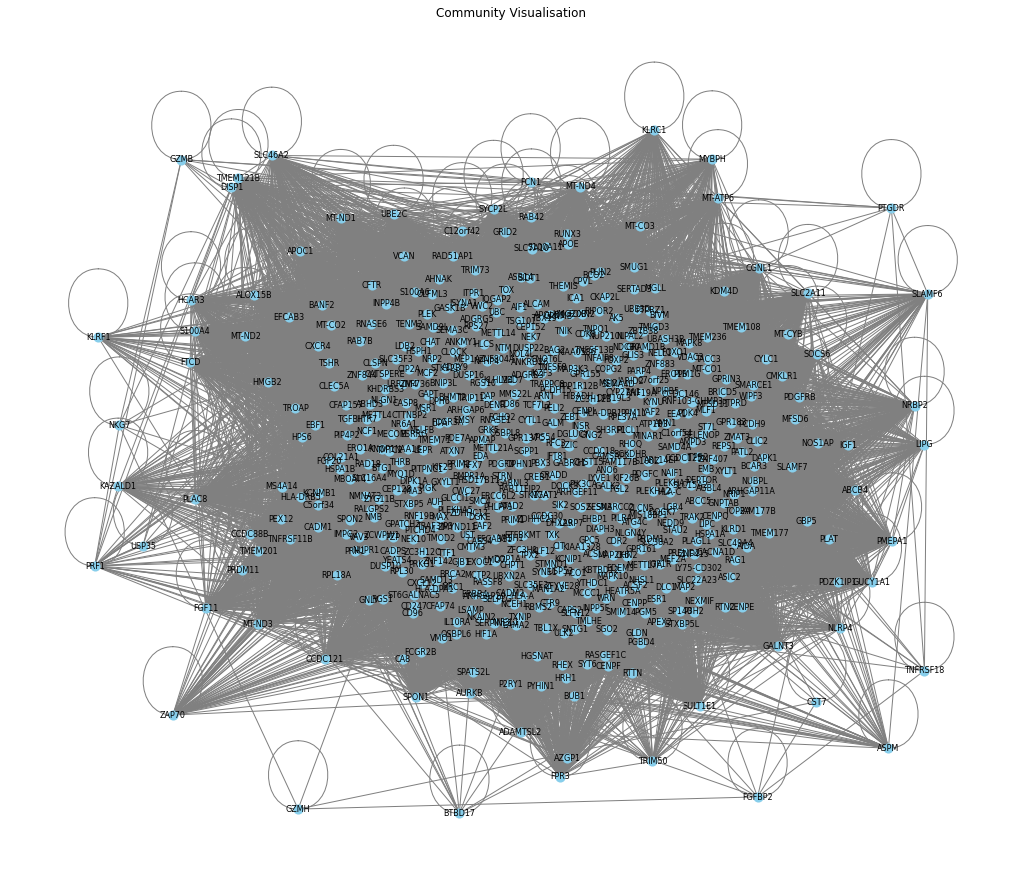

In [82]:
#Step 7:
# Visualise the subgraph
pos = nx.spring_layout(subgraph, k=0.8, iterations=20)  # You can use different layout algorithms if needed
plt.figure(figsize=(14, 12))
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=0.1, font_size=8)
plt.title('Community Visualisation')
plt.show()

In [24]:
#Play around with different layouts and see how the visualisation is affected.
#For example, there is circular_layout. Check out https://networkx.org/documentation/stable/tutorial.html#drawing-graphs for more information.

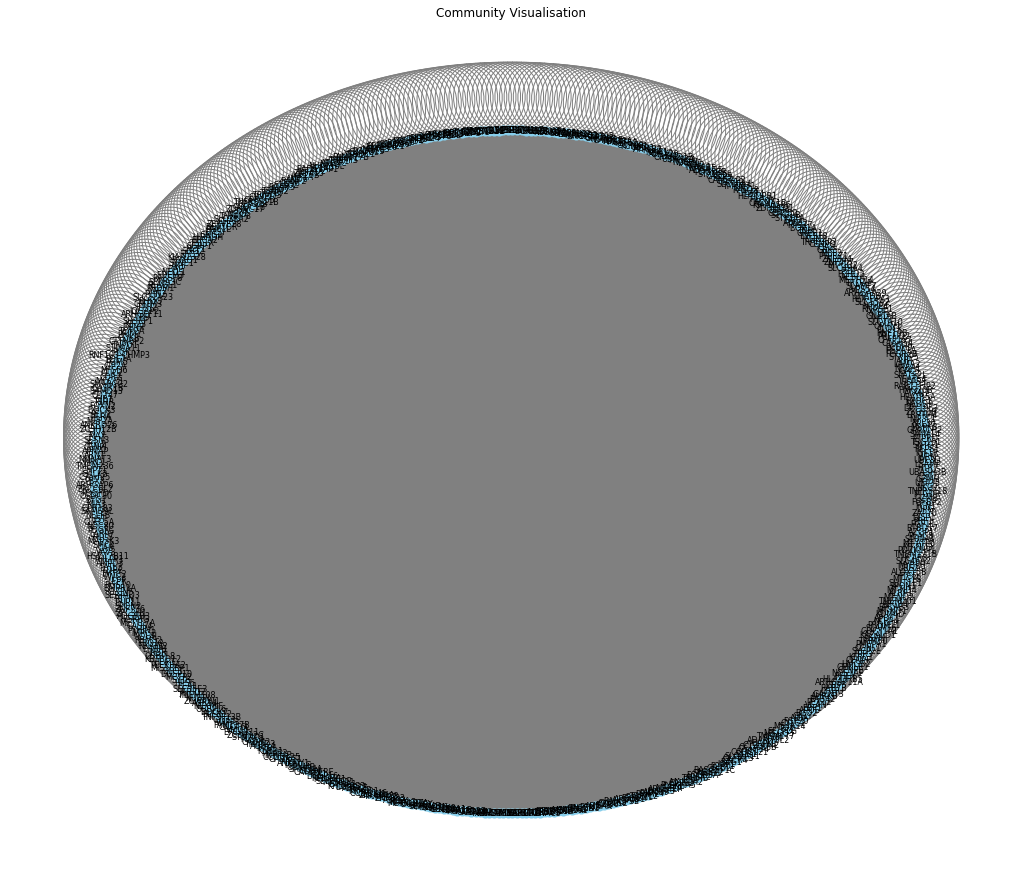

In [73]:
# Visualise the subgraph
pos = nx.circular_layout(subgraph)  # You can use different layout algorithms if needed
plt.figure(figsize=(14, 12))
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=0.1, font_size=8)
plt.title('Community Visualisation')
plt.show()
#As can be seen here, the circular layout is not really suitable due to the high number of genes within the sub-network

In [79]:
#Since the subnetwork itself is too large to visualise, we shall visualise a random sample of the subnetwork.
# Select 10 random nodes from the original subgraph
selected_nodes = random.sample(subgraph.nodes(), 10)

# Create a new subgraph containing only the selected nodes and their neighbors
reduced_subgraph = subgraph.subgraph(selected_nodes)

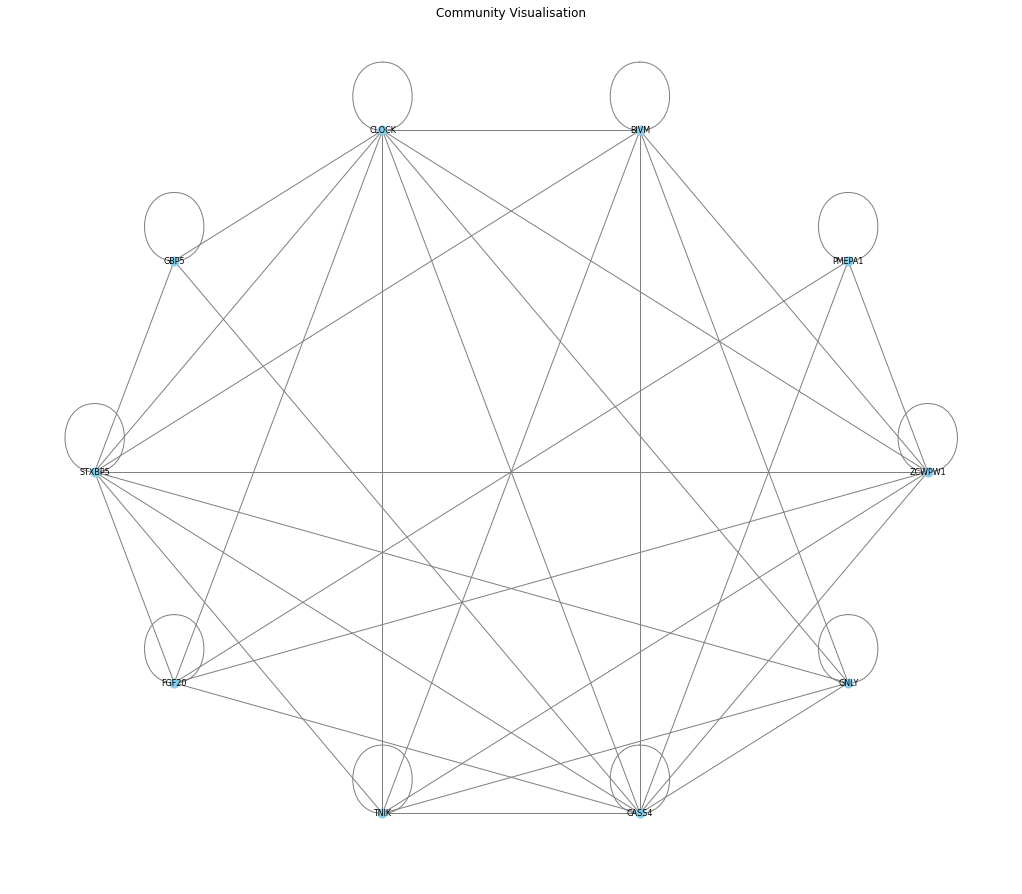

In [80]:
# Visualise the subgraph
pos = nx.circular_layout(reduced_subgraph)  # You can use different layout algorithms if needed
plt.figure(figsize=(14, 12))
nx.draw(reduced_subgraph, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=0.1, font_size=8)
plt.title('Community Visualisation')
plt.show()

In [ ]:
#Try out a different visualisation technique with the randomly sampled subnetwork

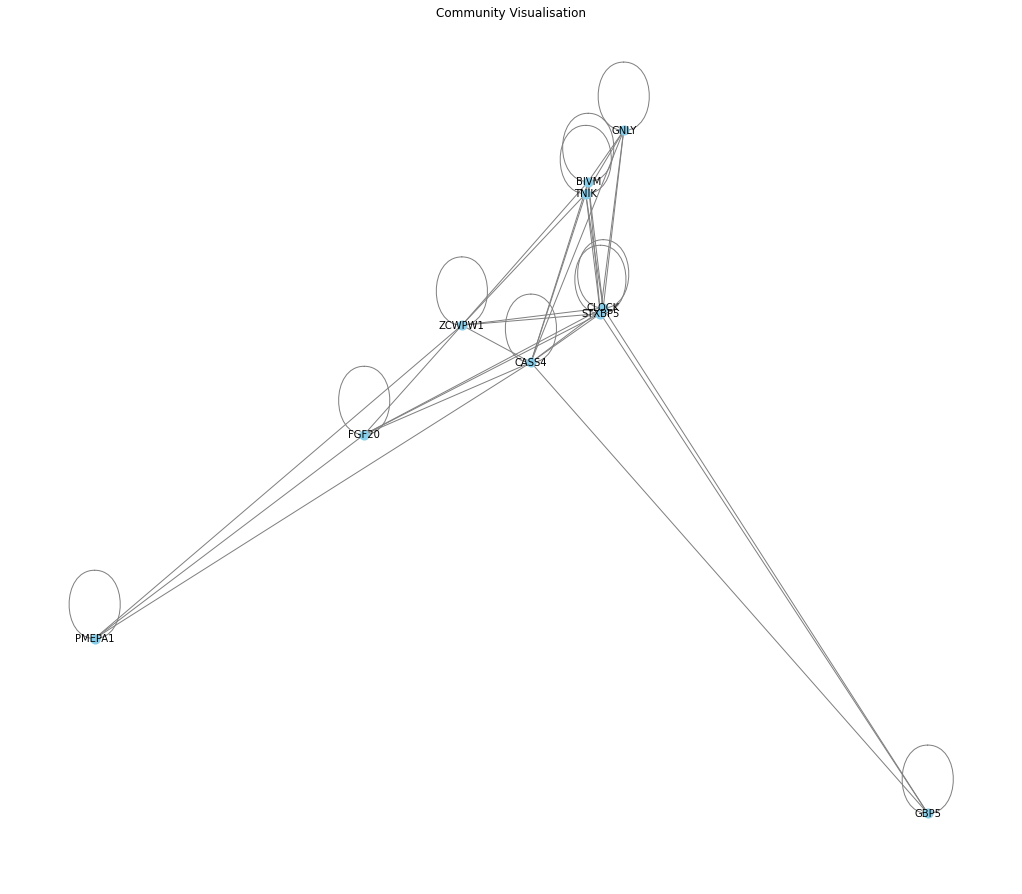

In [81]:
# Visualise the subgraph
pos = nx.spectral_layout(reduced_subgraph)  # You can use different layout algorithms if needed
plt.figure(figsize=(14, 12))
nx.draw(reduced_subgraph, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=0.1, font_size=10)
plt.title('Community Visualisation')
plt.show()

In [25]:
#Exercise Questions
#1. What other correlation measures could be used?
#2. What other distance measures could be used??
#3. Are there other community-based algorithms that could be used instead?
#4. Show a worked through example testing different correlation measures, distance measures and community algorithms
#and see how this affects the networks produced.

In [ ]:
#Answers:
#1. Spearman Rank Correlation: Measures the strength and direction of the monotonic relationship between two ranked variables. 
#Useful for ordinal data or when the relationship isn't linear.
#Kendall Tau Correlation: Measures the association between two ranked variables.
#Suitable for small sample sizes or data with many tied ranks.

#2. Euclidean Distance: The straight-line distance between two points in Euclidean space.
#Manhattan Distance: The sum of absolute differences between the coordinates of two points.
#Minkowski Distance: A generalisation that includes both Euclidean and Manhattan distances.
#By providing a comprehensive way to quantify relationships between objects, distance matrices play a fundamental role in data analysis, pattern recognition, and various scientific research fields.

#3. The Louvain method: Is an efficient algorithm for community detection that optimises modularity.
#The Girvan-Newman algorithm: Detects communities by progressively removing edges with the highest betweenness centrality.


In [ ]:
#4

In [26]:
#Calculate correlation using Spearman Rank Correlation:
correlation_matrix2 = datExpr.corr(method = 'spearman')

In [27]:
correlation_matrix2

,SAR1A,IER3,ATXN7,MRPL32,RASGEF1C,HMG20B,RAB11FIP2,GEM,TREM1,MEPE,...,MAN1A2,EDA,TMLHE,ECH1,APEX2,FCGR3A,SMUG1,HEATR5A,ARL2-SNX15,NRBP2
SAR1A,1.000000,0.930095,0.826752,0.923552,0.674775,0.784198,0.896341,0.896001,0.523823,0.845645,...,0.853659,0.851068,0.863226,0.825692,0.846732,0.772040,0.750000,0.942073,0.939024,0.753049
IER3,0.930095,1.000000,0.793939,0.847577,0.709091,0.721212,0.930095,0.956636,0.522233,0.863642,...,0.844989,0.830303,0.866667,0.750014,0.781632,0.781818,0.662617,0.924016,0.844989,0.765961
ATXN7,0.826752,0.793939,1.000000,0.835381,0.842424,0.915152,0.936175,0.734899,0.174078,0.781390,...,0.899700,0.975758,0.951515,0.798795,0.800391,0.878788,0.778119,0.893621,0.790277,0.589668
MRPL32,0.923552,0.847577,0.835381,1.000000,0.676842,0.780502,0.874622,0.844566,0.525427,0.889613,...,0.902145,0.865870,0.871967,0.828221,0.764393,0.859772,0.813459,0.902145,0.911319,0.694193
RASGEF1C,0.674775,0.709091,0.842424,0.676842,1.000000,0.721212,0.772040,0.544839,0.058026,0.712847,...,0.778119,0.806061,0.842424,0.506107,0.650318,0.624242,0.662617,0.668696,0.516720,0.693012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCGR3A,0.772040,0.781818,0.878788,0.859772,0.624242,0.903030,0.917937,0.785581,0.290129,0.760827,...,0.899700,0.939394,0.890909,0.908553,0.737860,1.000000,0.832831,0.844989,0.844989,0.480245
SMUG1,0.750000,0.662617,0.778119,0.813459,0.662617,0.911858,0.792683,0.632285,0.058203,0.694392,...,0.899390,0.869305,0.851068,0.825692,0.881229,0.832831,1.000000,0.670732,0.762195,0.640244
HEATR5A,0.942073,0.924016,0.893621,0.902145,0.668696,0.790277,0.939024,0.915065,0.523823,0.866271,...,0.844512,0.887542,0.893621,0.816518,0.777739,0.844989,0.670732,1.000000,0.893293,0.658537
ARL2-SNX15,0.939024,0.844989,0.790277,0.911319,0.516720,0.796356,0.859756,0.864228,0.523823,0.770019,...,0.835366,0.838910,0.790277,0.923552,0.790283,0.844989,0.762195,0.893293,1.000000,0.545732


In [31]:
#Calculate distance matrix using Minkowski Distance

# Convert correlation matrix to distance matrix
# Here, we use 1 - correlation as the distance measure by first calculating the dissimilarity
distance_matrix2 = 1 - correlation_matrix2

# Calculate the Minkowski distance (p = 2 for Euclidean, p = 1 for Manhattan, etc.)
p = 3  # You can change this to any value of p
minkowski_distances = pdist(distance_matrix2, metric='minkowski', p=p)

# Convert back to square form
distance_matrix_minkowski = squareform(minkowski_distances)


In [32]:
distance_matrix_minkowski

array([[0.        , 0.78456703, 1.64804131, ..., 0.78505804, 0.89469457,
        2.64761463],
       [0.78456703, 0.        , 1.73321346, ..., 0.80952434, 1.25425638,
        2.43661045],
       [1.64804131, 1.73321346, 0.        , ..., 1.28251947, 1.71225528,
        2.96077608],
       ...,
       [0.78505804, 0.80952434, 1.28251947, ..., 0.        , 1.0398553 ,
        2.82933276],
       [0.89469457, 1.25425638, 1.71225528, ..., 1.0398553 , 0.        ,
        2.90621087],
       [2.64761463, 2.43661045, 2.96077608, ..., 2.82933276, 2.90621087,
        0.        ]])

In [34]:
# Convert back to DataFrame to keep row and column names
#In order to do that save the row and column names from the original correlation matrix first:

row_labels = correlation_matrix.index
column_labels = correlation_matrix.columns

#Convert the distance matrix into a dataframe
distance_df = pd.DataFrame(distance_matrix_minkowski, index=row_labels, columns=column_labels)

In [35]:
distance_df

,SAR1A,IER3,ATXN7,MRPL32,RASGEF1C,HMG20B,RAB11FIP2,GEM,TREM1,MEPE,...,MAN1A2,EDA,TMLHE,ECH1,APEX2,FCGR3A,SMUG1,HEATR5A,ARL2-SNX15,NRBP2
SAR1A,0.000000,0.784567,1.648041,0.963497,2.514874,1.875638,1.239924,1.100569,5.360614,1.140627,...,1.456763,1.565982,1.466656,1.538215,1.464918,1.869919,1.999335,0.785058,0.894695,2.647615
IER3,0.784567,0.000000,1.733213,1.248624,2.388296,2.054174,1.163135,0.704571,5.193092,1.091000,...,1.531008,1.684675,1.493874,1.777077,1.632886,1.869657,2.207111,0.809524,1.254256,2.436610
ATXN7,1.648041,1.733213,0.000000,1.466647,1.898403,0.884293,0.916978,1.962210,5.977742,1.697558,...,0.935790,0.495896,0.695006,1.577918,1.387977,1.187448,1.555249,1.282519,1.712255,2.960776
MRPL32,0.963497,1.248624,1.466647,0.000000,2.498211,1.666198,1.190599,1.268394,5.411013,0.965238,...,1.112775,1.338179,1.285516,1.357811,1.581796,1.330397,1.620523,0.910843,0.965958,2.762500
RASGEF1C,2.514874,2.388296,1.898403,2.498211,0.000000,2.016380,2.382271,2.626865,5.054935,2.157072,...,2.203976,2.213760,2.054514,2.617928,1.919657,2.519768,1.991643,2.504168,2.736101,1.917241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCGR3A,1.869919,1.869657,1.187448,1.330397,2.519768,1.087365,1.157991,1.748575,5.652013,1.715540,...,1.052493,0.969225,1.197298,1.096542,1.628448,0.000000,1.401953,1.417432,1.456011,3.099998
SMUG1,1.999335,2.207111,1.555249,1.620523,1.991643,0.981852,1.798291,2.173028,5.445240,1.915496,...,1.304164,1.456098,1.512364,1.426708,1.068500,1.401953,0.000000,2.025607,1.776651,2.463801
HEATR5A,0.785058,0.809524,1.282519,0.910843,2.504168,1.678887,0.812675,1.020756,5.477525,1.113245,...,1.273404,1.226902,1.161921,1.434038,1.610170,1.417432,2.025607,0.000000,1.039855,2.829333
ARL2-SNX15,0.894695,1.254256,1.712255,0.965958,2.736101,1.703358,1.404971,1.147138,5.147406,1.382549,...,1.478130,1.587965,1.694800,0.913830,1.550799,1.456011,1.776651,1.039855,0.000000,2.906211


/tmp/ipykernel_656066/2932722225.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix2 = sch.linkage(distance_df, method='average')


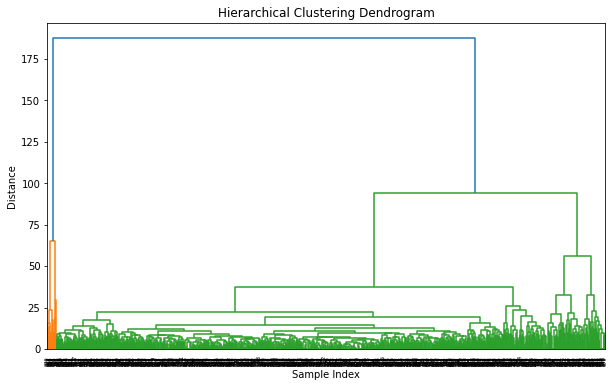

In [37]:
#The linkage function is used to perform hierarchical clustering on the distance matrix. 
linkage_matrix2 = sch.linkage(distance_df, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(linkage_matrix2)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [42]:
# Define threshold for significant edges (you can adjust this based on your requirement)
threshold = 0.7

# Threshold the correlation matrix to determine significant edges
significant_edges2 = correlation_matrix2 > threshold

In [43]:
significant_edges2

,SAR1A,IER3,ATXN7,MRPL32,RASGEF1C,HMG20B,RAB11FIP2,GEM,TREM1,MEPE,...,MAN1A2,EDA,TMLHE,ECH1,APEX2,FCGR3A,SMUG1,HEATR5A,ARL2-SNX15,NRBP2
SAR1A,True,True,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
IER3,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,False,True,True,True
ATXN7,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,False
MRPL32,True,True,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,False
RASGEF1C,False,True,True,False,True,True,True,False,False,True,...,True,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCGR3A,True,True,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,False
SMUG1,True,False,True,True,False,True,True,False,False,False,...,True,True,True,True,True,True,True,False,True,False
HEATR5A,True,True,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,False,True,True,False
ARL2-SNX15,True,True,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,False


In [44]:
#networkx is a python library designed for network analysis.
# Construct the network from significant edges.
G2 = nx.Graph()

# Loop through significant edges and add edges to the graph
for i in range(significant_edges2.shape[0]):
    for j in range(significant_edges2.shape[1]):
        if significant_edges2.values[i, j]:
            gene1 = significant_edges2.index[i]
            gene2 = significant_edges2.columns[j]
            
            # Find the position of gene1 and gene2 in the correlation matrix
            i_corr = np.where(correlation_matrix2.index == gene1)[0][0]
            j_corr = np.where(correlation_matrix2.columns == gene2)[0][0]
            
            # Add the edge to the graph
            G2.add_edge(gene1, gene2, weight=correlation_matrix2.iloc[i_corr, j_corr])

# Display the number of nodes and edges in the graph
print("Number of nodes:", G2.number_of_nodes())
print("Number of edges:", G2.number_of_edges())

Number of nodes: 999
Number of edges: 332323


In [58]:
# Analyse the network
# For example, you can identify clusters/modules using community detection algorithms
#Connected_components is a quick and simple community detection algorithm. 
#While this method may not be as sophisticated as algorithms like Louvain or Girvan-Newman, it can provide a basic partitioning of the graph into communities.
communities2 = list(nx.connected_components(G2))

In [60]:
communities2

[{'AANAT',
  'ABCB4',
  'ABCC5',
  'ABCG4',
  'ABHD3',
  'ACAT1',
  'ACO1',
  'ACSF2',
  'ACSL4',
  'ADAMTS17',
  'ADAMTSL2',
  'ADCY9',
  'ADGRB3',
  'ADGRE2',
  'ADGRG5',
  'ADGRL3',
  'ADM',
  'ADTRP',
  'AGBL4',
  'AHNAK',
  'AIDA',
  'AIF1',
  'AK5',
  'ALCAM',
  'ALDH1A2',
  'ALKBH1',
  'ALOX15B',
  'ALOX5AP',
  'ALPK3',
  'AMN1',
  'AMPD3',
  'ANGPT2',
  'ANGPTL1',
  'ANGPTL4',
  'ANKMY1',
  'ANKRD22',
  'ANKRD26',
  'ANKRD37',
  'ANO6',
  'ANXA3',
  'APCDD1L',
  'APEX2',
  'APMAP',
  'APOC1',
  'APOD',
  'APOE',
  'APOLD1',
  'ARHGAP11A',
  'ARHGAP18',
  'ARHGAP20',
  'ARHGAP29',
  'ARHGAP6',
  'ARHGEF11',
  'ARHGEF12',
  'ARL14EP',
  'ARL2-SNX15',
  'ARNT',
  'ARPP21',
  'ASB14',
  'ASB7',
  'ASGR1',
  'ASIC2',
  'ASPM',
  'ATAD2',
  'ATG4C',
  'ATP11C',
  'ATP1B3',
  'ATP2B4',
  'ATP6V1G2',
  'ATXN7',
  'AUH',
  'AURKB',
  'AZGP1',
  'B2M',
  'B3GALT2',
  'BAG2',
  'BANF2',
  'BATF2',
  'BCAR3',
  'BCAS2',
  'BCKDHB',
  'BCL2A1',
  'BCO2',
  'BHMT2',
  'BID',
  'BIRC3',
  'BI

In [63]:
# Initialise a new graph for community visualisation
community_graph2 = nx.Graph()

In [64]:
# Add edges between communities based on their connectivity
for i, community in enumerate(communities2):
    for node in community:
        community_graph2.add_node(node)
        for neighbor in G2.neighbors(node):
            if neighbor in community:
                community_graph2.add_edge(node, neighbor, weight=G2[node][neighbor]['weight'])


In [65]:
# Initialise an empty list to store separated communities
separated_communities = []

# Iterate over the detected communities
for community in communities:
    # Convert the set of nodes into a list and append it to the list of lists
    separated_communities.append(list(community))

In [66]:
# Print or use the separated communities as needed
print(separated_communities)

[['RPL37A', 'SAMD9L', 'SNTG1', 'MECOM', 'OPHN1', 'PBX3', 'RIPOR2', 'NUP210L', 'MSI2', 'GAPT', 'P3H2', 'APOLD1', 'ICA1', 'NOS1AP', 'CWC27', 'LMO7', 'PLAGL1', 'PEX12', 'ULK2', 'GPNMB', 'GALK2', 'INSR', 'AIF1', 'SYNE1', 'SIDT1', 'ZNF844', 'DGKE', 'MT-CO1', 'PRELID2', 'PRH1', 'SGPP1', 'CPVL', 'PGM5', 'PLIN2', 'CHPT1', 'CYTL1', 'C12orf42', 'S100A4', 'AHNAK', 'DGLUCY', 'CNOT6L', 'RAD51AP1', 'STXBP5L', 'CFTR', 'ZCWPW1', 'TXK', 'CHAT', 'ABCB4', 'INPP4B', 'GLIS3', 'CD247', 'CAPS2', 'MFSD11', 'BCKDHB', 'ZC3H12B', 'METTL14', 'NEDD9', 'LEPR', 'FOXN2', 'S100A11', 'CACNA1D', 'NELL1', 'AIDA', 'ST6GALNAC5', 'MCTP2', 'CADM1', 'CMTM3', 'CENPQ', 'ERO1B', 'THEMIS', 'HSPH1', 'KYNU', 'CTTNBP2', 'MAP2', 'CGNL1', 'TRIM73', 'PLAT', 'TNFSF8', 'ASIC2', 'GRID2', 'ADGRB3', 'ZNF407', 'GPR155', 'MIA3', 'KIF26B', 'UBE3D', 'APOC1', 'SPATS2L', 'CKAP2L', 'MT-CYB', 'TMEM71', 'MSR1', 'CRADD', 'GPC5', 'TMOD2', 'MGAT1', 'DENR', 'FGF20', 'METTL21A', 'KCNMB1', 'FGL2', 'PYHIN1', 'DUSP22', 'NAIF1', 'RGS10', 'BAG2', 'STK32B', 'S

In [67]:
len(communities2)

7

In [68]:
# Choose the index of the community you want to visualize
community_index2 = 0  # Change this to the index of the community you want to visualise

# Get the nodes in the selected community
selected_community2 = list(communities2[community_index2])

# Create a subgraph containing only the nodes and edges within the selected community
subgraph2 = G2.subgraph(selected_community2)

In [69]:
# Assuming subgraph is already defined
num_nodes = subgraph.number_of_nodes()
print(f"The number of nodes in the subgraph is: {num_nodes}")

The number of nodes in the subgraph is: 569


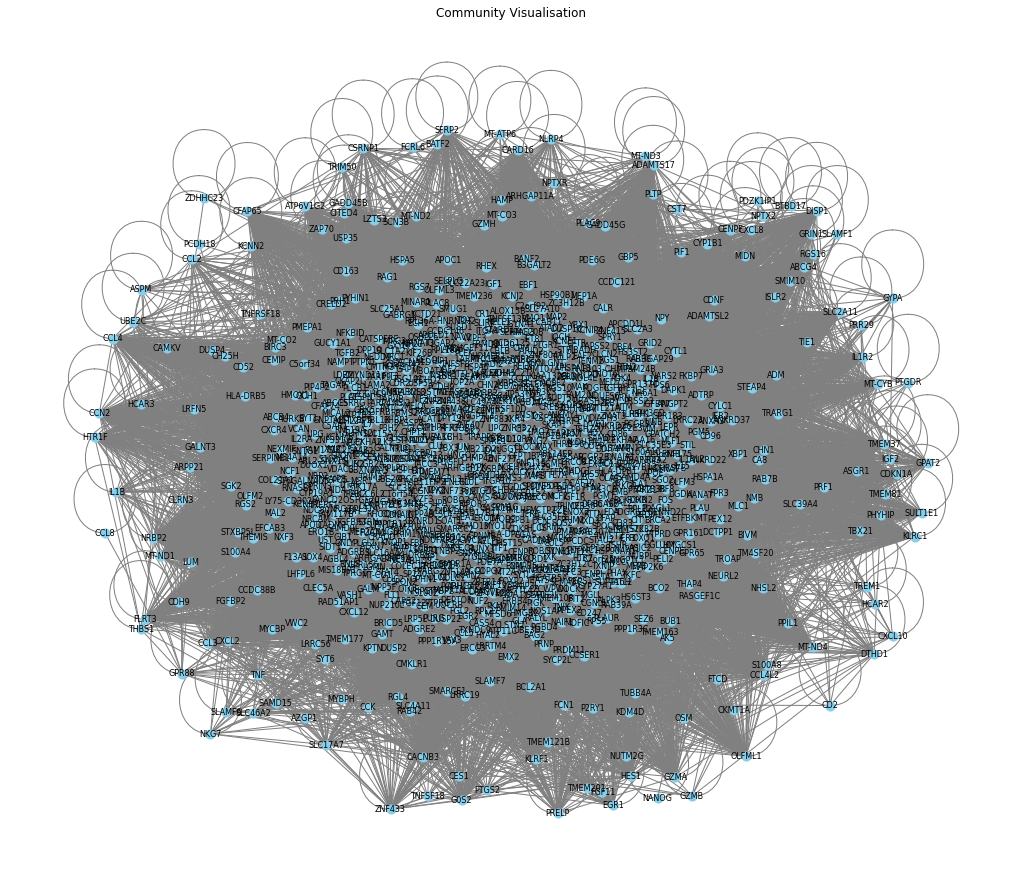

In [70]:
#Step 7:
# Visualise the subgraph
pos = nx.spring_layout(subgraph2, k=0.8, iterations=20)  # You can use different layout algorithms if needed
plt.figure(figsize=(14, 12))
nx.draw(subgraph2, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=0.1, font_size=8)
plt.title('Community Visualisation')
plt.show()